#### 주제 
용접 실적 분석

#### 배경
- 인구 감소 및 고기량자 이직으로 인한 자동화 필요성, 더 나아가 자동화 시스템으로 인해 생산된 제품의 품질을 높이고 완전 자동화의 필요성 대두
#### 목적
- AI를 활용해 로봇 용접과정에서 발생하는 품질문제 해결위해 생산조건 최적화를 데이터 분석과 인공지능 모델 개발을 통해 달성하고자함

#### 버전
!pip install torch==2.3.1+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cpu
!pip install torchvision==0.18.1+cpu --index-url https://download.pytorch.org/whl/cpu

### import & load

In [1]:
import pandas as pd
import numpy as np
import os
import openpyxl

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn

from sklearn import preprocessing
import sklearn.metrics as metric


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\samsung\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\samsung\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp

In [5]:
df = pd.read_excel('./data/Welding Data Set_01.xlsx')
df.head()

,idx,Machine_Name,Item No,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
0,1,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.33,14.57,2.701,72.0
1,2,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.57,2.701,72.0
2,3,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,71.0
3,4,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,72.0
4,5,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.56,2.704,72.0


### EDA

In [6]:
for feature in welding_data:
    print(feature, df[feature].value_counts())

idx idx
641     9
642     9
643     9
644     9
645     9
       ..
1996    1
1997    1
1998    1
1999    1
2000    1
Name: count, Length: 2000, dtype: int64
Machine_Name Machine_Name
Spot-01    11939
Name: count, dtype: int64
Item No Item No
65235-25800    11939
Name: count, dtype: int64
working time working time
2020-04-02    2000
2020-03-31    1800
2020-03-27    1648
2020-03-30    1470
2020-03-25    1352
2020-03-24    1200
2020-03-26    1000
2020-04-03     800
2020-04-07     669
Name: count, dtype: int64
Thickness 1(mm) Thickness 1(mm)
0.7    11939
Name: count, dtype: int64
Thickness 2(mm) Thickness 2(mm)
0.7    11939
Name: count, dtype: int64
weld force(bar) weld force(bar)
2.31    1237
2.33    1062
2.35    1047
2.32    1036
2.36    1030
        ... 
8.92       4
7.87       4
2.23       2
2.36       2
2.19       2
Name: count, Length: 177, dtype: int64
weld current(kA) weld current(kA)
14.73    1284
14.74    1276
14.75    1002
14.72     771
14.59     630
14.76     612
14.71     553

In [7]:
df.describe()

,idx,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
count,11939.000000,11939,11939.0,11939.0,11939.000000,11939.000000,11939.000000,11939.000000
mean,732.280761,2020-03-29 10:49:44.571572224,0.7,0.7,2.787925,14.711208,2.704223,71.724123
min,1.000000,2020-03-24 00:00:00,0.7,0.7,1.740000,14.520000,2.464000,70.000000
25%,332.000000,2020-03-26 00:00:00,0.7,0.7,2.310000,14.610000,2.699000,71.000000
50%,664.000000,2020-03-30 00:00:00,0.7,0.7,2.340000,14.730000,2.702000,72.000000
75%,1081.000000,2020-04-02 00:00:00,0.7,0.7,2.370000,14.750000,2.706000,72.000000
max,2000.000000,2020-04-07 00:00:00,0.7,0.7,10.540000,15.070000,2.861000,73.000000
std,481.996313,NaN,0.0,0.0,1.455966,0.099000,0.024700,0.632049


<Axes: >

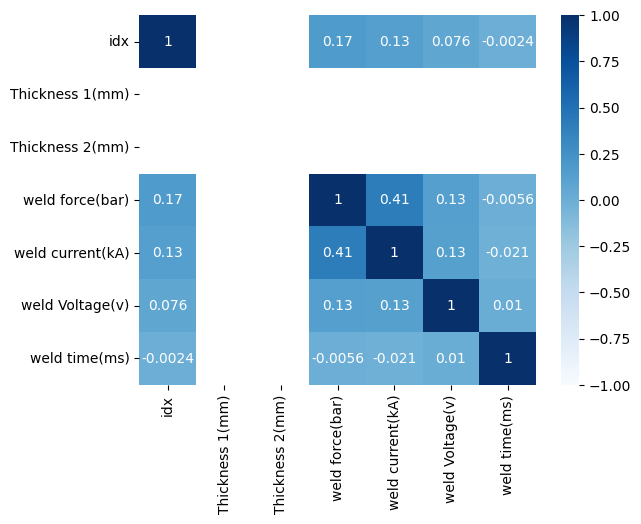

In [8]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues',
            vmin=-1,vmax=1,)


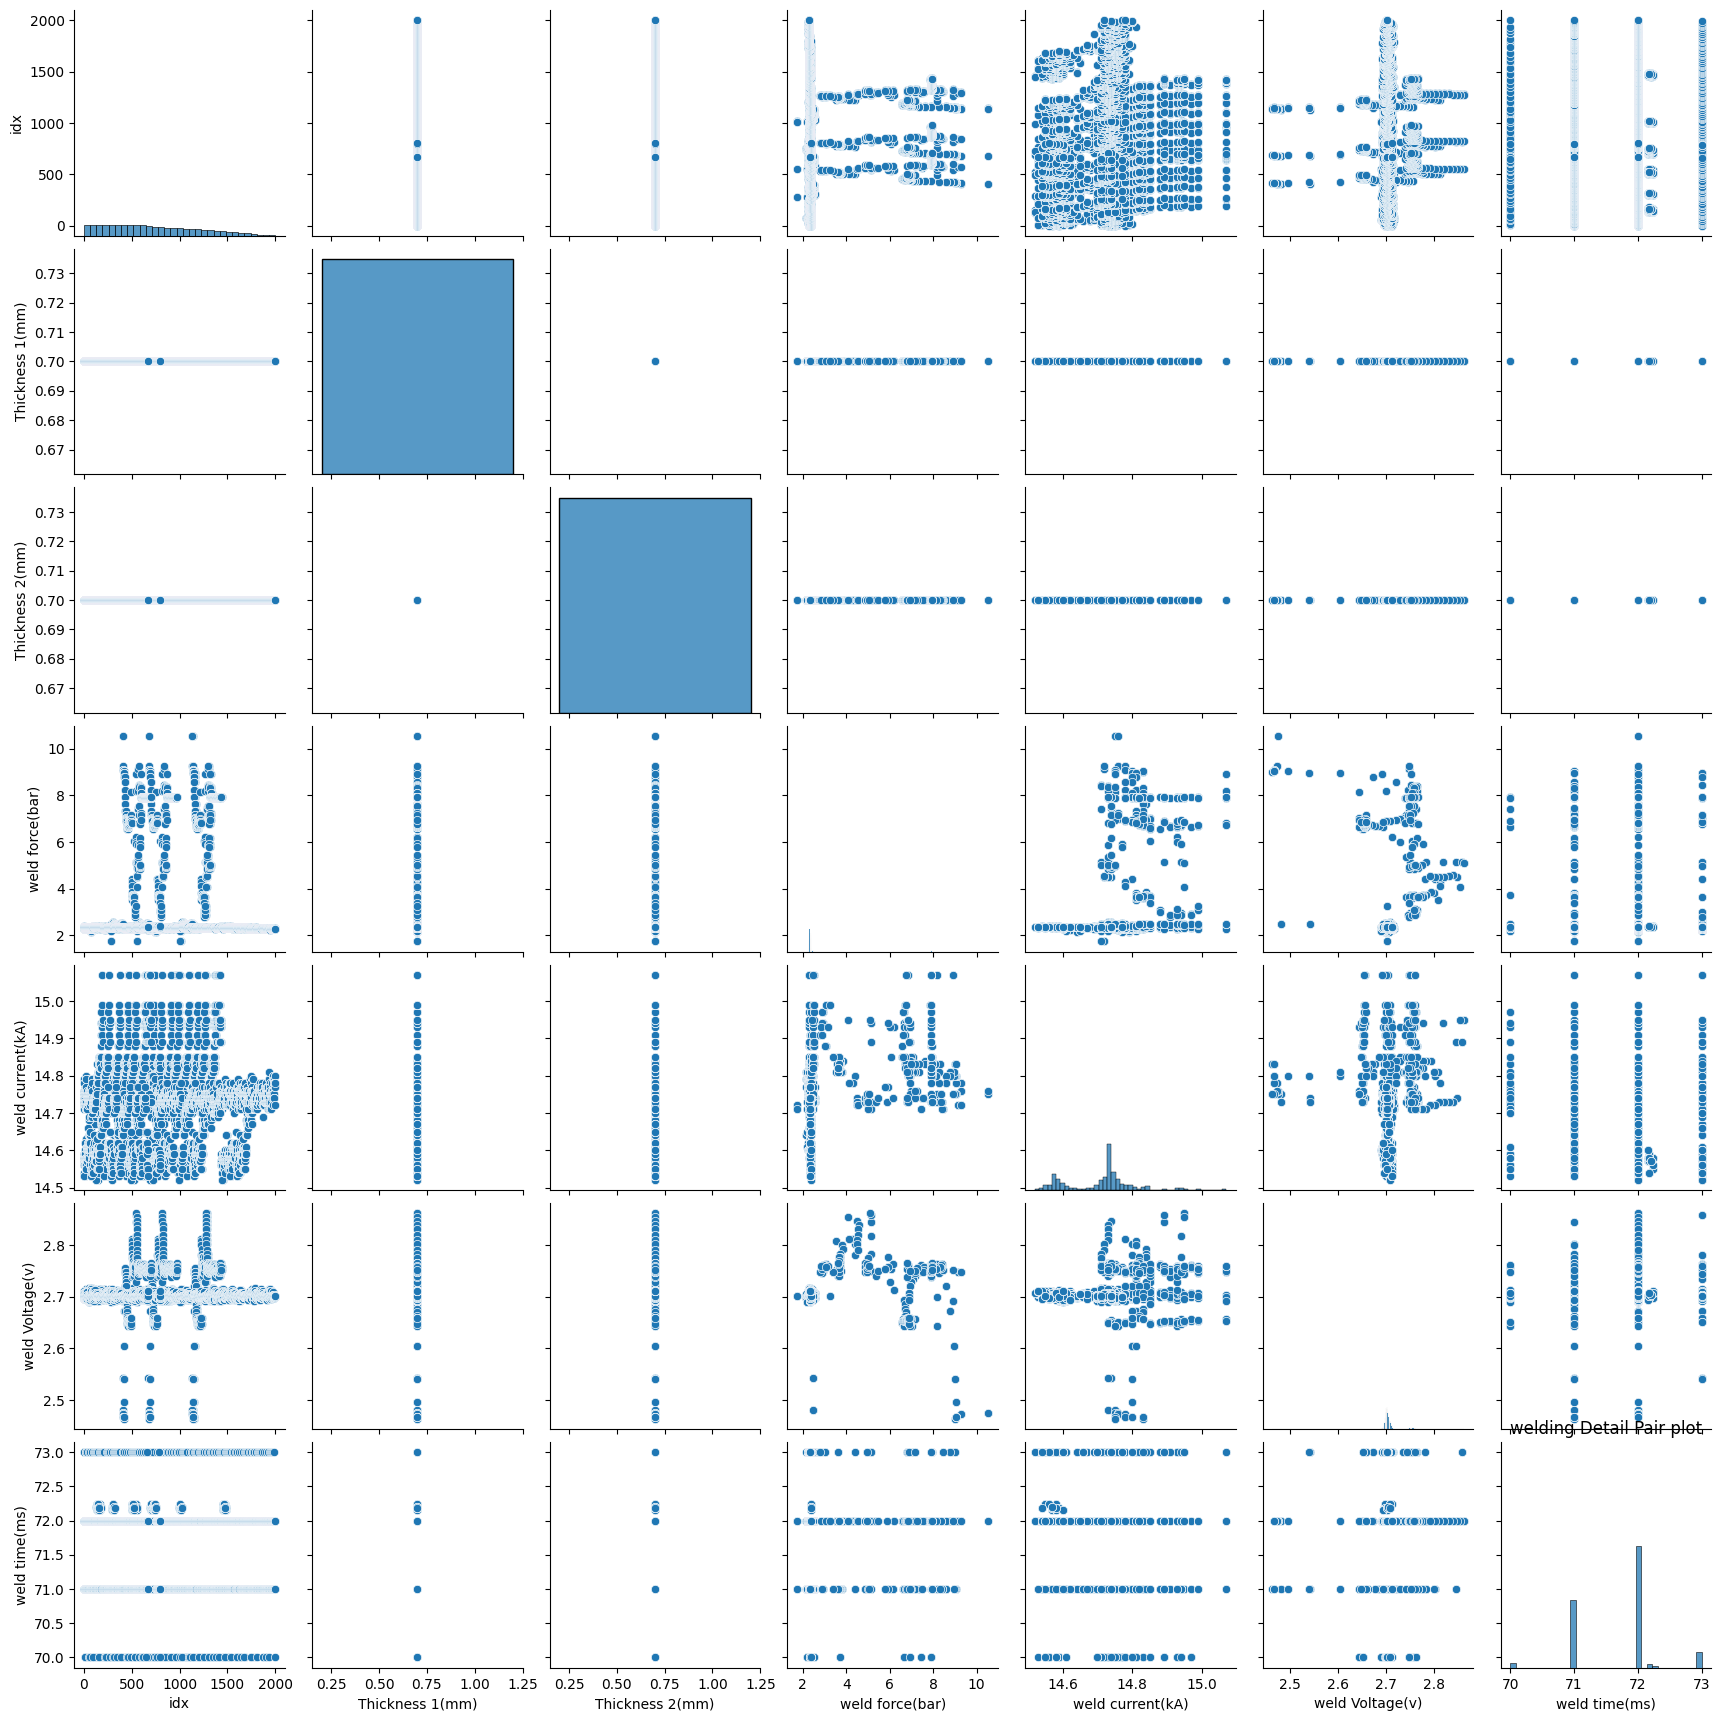

In [27]:
sns.pairplot(df)
plt.title('welding Detail Pair plot')
plt.show()

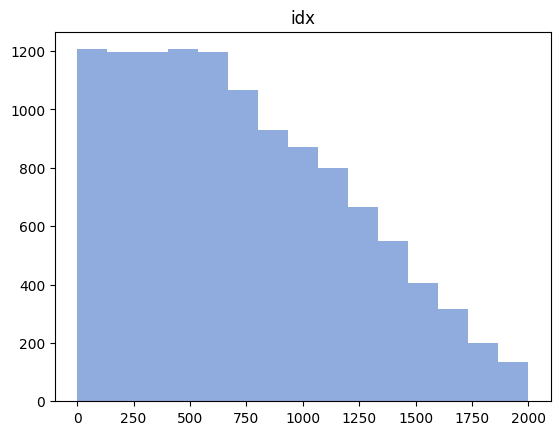

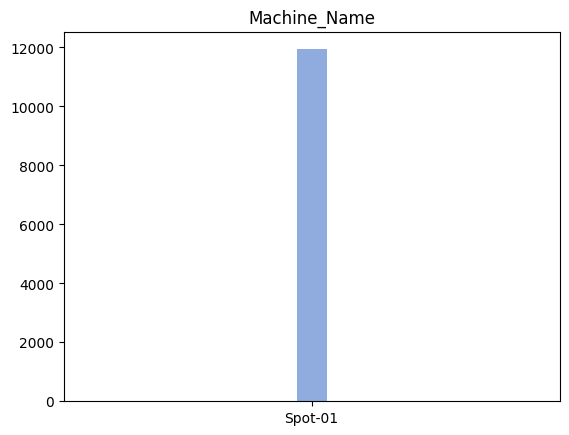

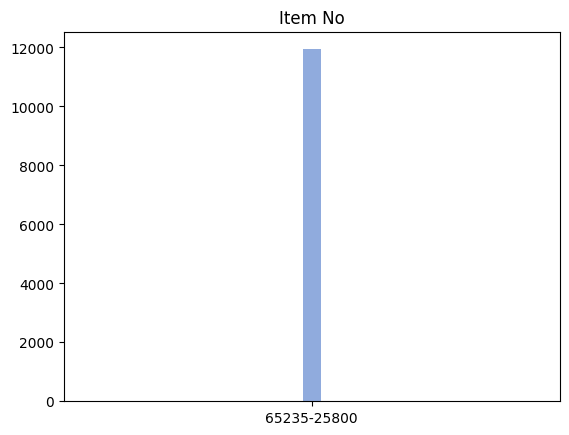

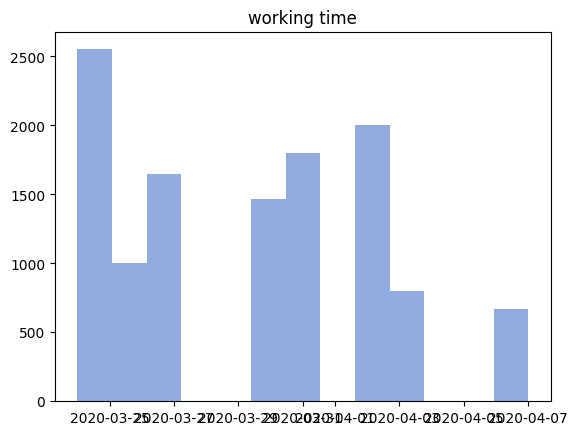

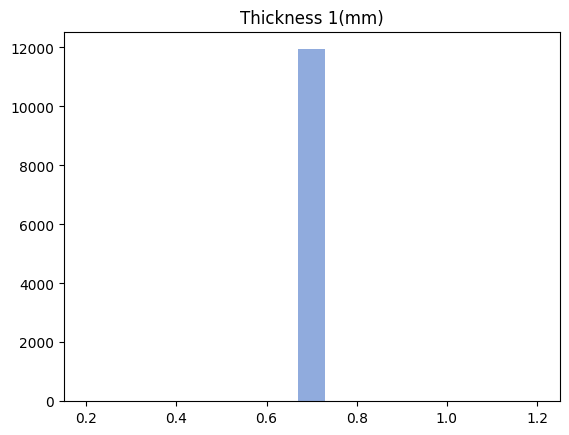

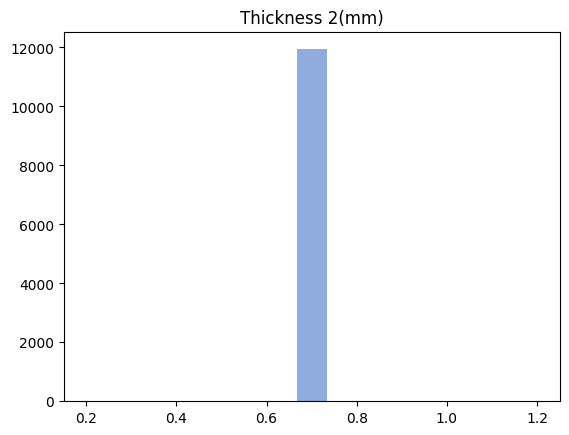

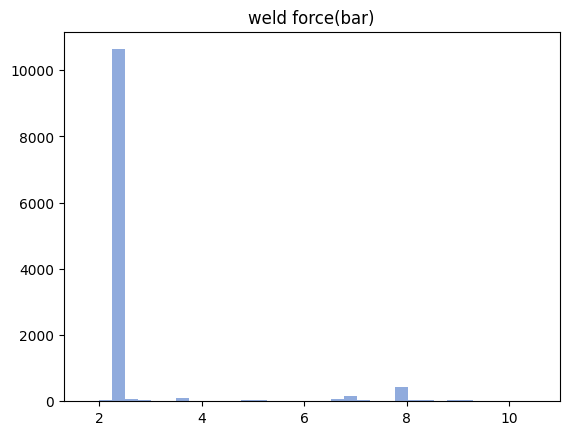

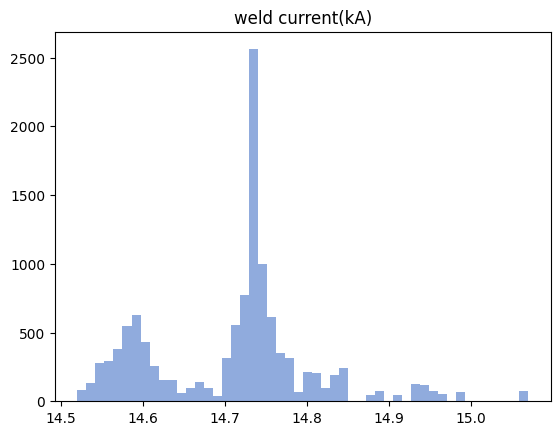

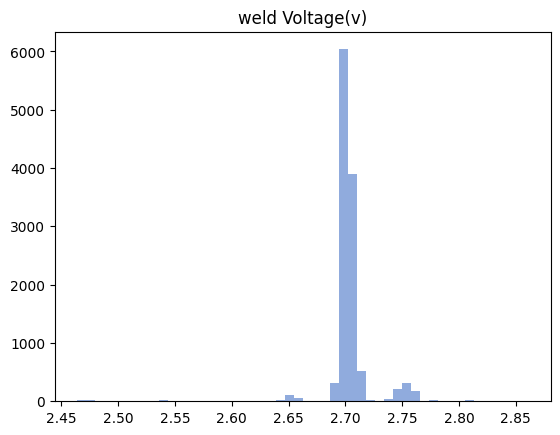

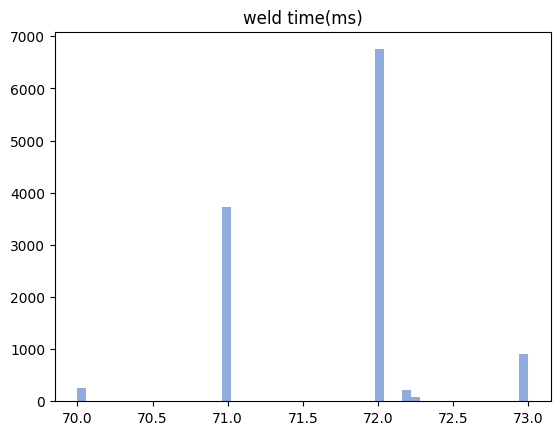

In [10]:
# feature histogram
b = [15,15,25,13,17,15,35,50,50,50]
for index, value in enumerate(df.columns):
    plt.figure(index)
    plt.hist(welding_data[value], bins = b[index], facecolor = (144/255, 171/255, 221/255))
    plt.title(value)
    plt.savefig("./chart/" + value + '.png')

### data preprocessing

In [11]:
# select feature
new_df = df.iloc[:, 6:] # (생산품목, 작업시간, 소재두께)을 제외
new_df.head()

,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
0,2.33,14.57,2.701,72.0
1,2.36,14.57,2.701,72.0
2,2.37,14.54,2.703,71.0
3,2.37,14.54,2.703,72.0
4,2.36,14.56,2.704,72.0


In [12]:
# scaler - MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(new_df)
scaler_data = scaler.transform(new_df)

In [13]:
# encoder - AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AutoEncoder, self).__init__()
        ## initalize
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        ## 오토인코더 구현
        self.AutoEncoder = nn.Sequential(
        ## 인코더 부분
            nn.Linear(input_size, hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0], output_size),
            nn.RReLU(),
            ## 디코더 부분
            nn.Linear(output_size, hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0], input_size)            
        )
        
    def forward(self, inputs):
        output = self.AutoEncoder(inputs)
        return output

In [14]:
# train/ test split
train_data = torch.Tensor(scaler_data[:8470]) ## [:8470] 처음부터 8469번 까지의 데이터를 훈련 세트로 지정
print(len(train_data))
test_data = torch.Tensor(scaler_data[8470:])
print(len(test_data))

8470
3469


In [15]:
# define hyper params, loss function, optimizer

# 훈련 하이퍼파라미터
epoch = 50
batch_size = 64
lr = 0.01

# 모델 하이퍼파라미터
input_size = len(train_data[0])
hidden_size = [3]
output_size = 2

# 손실 함수로 제곱근 오차 사용
criterion = nn.MSELoss()

# 매개변수 조정 방식으로 Adam사용
optimizer = torch.optim.Adam

# 오토인코더 정의
AutoEncoder = AutoEncoder(input_size, hidden_size, output_size)

##########################################################################
# nn.MSELoss() : 평균 제곱근 오차 계산 함수
# torch.optim.Adam : 매개변수 조정 방식으로 Adam으로 설정
# AutoEncoder(input, hidden, output) : 앞에서 구현한 오토인코더 클래스를 정의
##########################################################################

In [16]:
# 8) 오토인코더 학습 함수 정의 및 학습
##########################################################################
# 학습 함수 정의 가이드
# AutoEncoder.parameters() : 현재 오토인코더에 내재되어있는 매개 변수
# DataLoader(data, batch_size, shuffle) : Pytorch에서 제공하는 함수로, 데이터를 
# 배치 사이즈로 나누며 shuffle은 훈련과정에서 데이터를 섞는지에 대한 여부
# optim.zero_grad() : 매개변수를 0으로 초기화시켜주는 함수
# loss.backward(), optim.step() : 매개변수를 손실 값을 기준으로 조정해주는 함수
# {}{},format(a,b) : 문장을 출력해줄 경우, {}자리에 특정 변수값(a,b가 가지는 값)을
# 넣어 출력해주는 함수
# running_loss += loss.item() : 데이터를 학습하면서 발생하는 손실 값을 추적하기 위한
#  손실 값 기록. running_loss를 통해 현재 손실값이 얼마인지 알 수 있음

In [28]:
 # define train fuction
def train_net(AutoEncoder, data, criterion, epochs, lr_rate=0.01):
    # Optimizer에 대한 정의
    optim = optimizer(AutoEncoder.parameters(), lr=lr_rate)

    # 배치 학습을 시키기 위한 데이터 변환
    data_iter = DataLoader(data, batch_size=batch_size, shuffle=True) 

    # 에포크 학습
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x in data_iter:
            # 매개변수 0으로 초기화
            optim.zero_grad()
            output =- AutoEncoder(x)
            # 입력값과 출력값간의 차이인 손실값
            loss = criterion(x, output)
            # 손실값을 기준으로 매개변수 조정
            loss.backward()
            optim.step()
            running_loss += loss.item()

        # 각 에포크마다 손실 값 표기
        #print("epoch:{}, loss: {:.2f}",format(epoch, running_loss))
        print("epoch:",format(epoch))
        print("loss:",format(running_loss))
    return AutoEncoder

In [32]:
# 8-2) 학습 함수를 이용한 오토인코더 학습
AutoEncoder = train_net(AutoEncoder, train_data, criterion, epoch, lr)

epoch: 1
loss: 0.3046705187589396
epoch: 2
loss: 0.2746165305725299
epoch: 3
loss: 0.27248176289140247
epoch: 4
loss: 0.27392950511421077
epoch: 5
loss: 0.27600175866973586
epoch: 6
loss: 0.2709357356361579
epoch: 7
loss: 0.2753298734605778
epoch: 8
loss: 0.27589365595486015
epoch: 9
loss: 0.2755967441771645
epoch: 10
loss: 0.2741213402914582
epoch: 11
loss: 0.27688738552387804
epoch: 12
loss: 0.2706855473516043
epoch: 13
loss: 0.27504542452516034
epoch: 14
loss: 0.27764774215756916
epoch: 15
loss: 0.2770751061907504
epoch: 16
loss: 0.2755297251569573
epoch: 17
loss: 0.2763656152819749
epoch: 18
loss: 0.27642286207992584
epoch: 19
loss: 0.275323520792881
epoch: 20
loss: 0.27409932677983306
epoch: 21
loss: 0.27316822845023125
epoch: 22
loss: 0.27474282987532206
epoch: 23
loss: 0.2784828800067771
epoch: 24
loss: 0.27753579057753086
epoch: 25
loss: 0.27429164029308595
epoch: 26
loss: 0.2750101609271951
epoch: 27
loss: 0.2728302332398016
epoch: 28
loss: 0.281013995379908
epoch: 29
loss: 0.

In [57]:
# 9) 임계값 정의 후 결과 분석 및 해석
# 훈련세트의 손실값 이용한 임계값 정의
train_loss_chart = []
for data in train_data:
    output = AutoEncoder(data)
    loss = criterion(output, data)
    train_loss_chart.append(loss.item())
    # print(loss.item())

threshold = np.mean(train_loss_chart) + np.std(train_loss_chart)*2.6
print("Threshold :", threshold)

Threshold : 1.8089597247560298


In [58]:
# 9-2) 분석 결과값 도출
#  훈련세트의 손실값 이용한 임계값 정의
test_loss_chart = []
for data in train_data:
    ouput = AutoEncoder(data)
    loss = criterion(output, data)
    test_loss_chart.append(loss.item())
    # print(loss.item())

outlier = list(test_loss_chart >= threshold)
outlier.count(True)

24